# Code for Gels

Axisymmetric swelling of a  cylinder

Degrees of freedom:
#
Displacement: u \
pressure: p \
chemical potential: mu \
concentration: c 

Units:
#
Length: mm \
Mass: kg \
Time: s \
Mass density: kg/mm^3 \
Force: milliN \
Stress: kPa \
Energy: microJ \
Temperature: K \
Amount of substance: mol \
Species concentration: mol/mm^3 \
Chemical potential: milliJ/mol \
Molar volume: mm^3/mol \
Species diffusivity: mm^2/s \
Gas constant: microJ/(mol K) 

Eric Stewart and Lallit Anand   
ericstew@mit.edu and anand@mit.edu   



Converted to FEniCSx by Jorge Nin
jorgenin@mit.edu
October 2023



In [1]:
import numpy as np
import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split)
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

### Set level of detail for log messages (integer)
Guide: \
CRITICAL  = 50  errors that may lead to data corruption \
ERROR     = 40  things that HAVE gone wrong \
WARNING   = 30  things that MAY go wrong later \
INFO      = 20  information of general interest (includes solver info) \
PROGRESS  = 16  what's happening (broadly) \
TRACE     = 13  what's happening (in detail) \
DBG       = 10  sundry 


In [2]:
log.set_log_level(log.LogLevel.WARNING)

# Define Geometry

In [3]:
problemName = "THERMO_GEL6_axi_swell"
# Create mesh 
r_in   = 3 # inner packer radius
r_out  = 9 # outer packer radius
r_wall = 11 # outer rigid wall radius
L0     = 6 # axial length of packer
domain = mesh.create_rectangle(MPI.COMM_WORLD,[[r_in,0.0],[r_out,L0]],[10,10])

### Visualize Gemometry

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:61388/index.html?ui=P_0x29e0c47d0_0&reconnect=auto' style='width: …

## Functions for finding Differnent Areas

In [5]:
def Left(x):
    return np.isclose(x[0], r_in)
def Right(x):
    return np.isclose(x[0], r_out)
def Bottom(x):
    return np.isclose(x[1], 0)
def Top(x):
    return np.isclose(x[1], L0)

def Ground(x):
        return np.logical_and(np.isclose(x[0],r_in) , np.isclose(x[1], 0))

In [6]:
boundaries = [(1, Left),(2,Bottom),(3,Right),(4,Top)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim-1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)

## SubRoutine

In [7]:
t          = 0.0        # initialization of time
ttd        = 300      # time constant for increasing mu
step1_time = 3600*2    
# 
tRamp      = 3600*2     # ramp time for increasing / decreasing temperature
#
step2_time = 3600*3     # ramp time+ hold time for increasing temp.
#
step3_time = 3600*3     # ramp time+ hold time for decreasing temp.
#
Ttot       = step1_time + step2_time + step3_time 
dt         = 50      

In [8]:
from subroutines import *
FenicxProblem = THERMO_GEL_Axial_Symmetric(domain)
FenicxProblem.Kinematics()
FenicxProblem.WeakForms(dt)

## Simulation Control

In [9]:
def muAmp(t):
    return float(FenicxProblem.mu0)*np.exp(-t/ttd)


# Boundary Conditions

In [10]:
Time_cons = Constant(domain,PETSc.ScalarType(muAmp(t)))

V0, submap = FenicxProblem.ME.sub(0).collapse()
fixed_displacement = fem.Function(V0)
fixed_displacement.interpolate(lambda x: np.stack((np.zeros(x.shape[1]), np.zeros(x.shape[1]))))

dofs_1 = fem.locate_dofs_topological(FenicxProblem.ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
dofs_2 = fem.locate_dofs_geometrical((FenicxProblem.ME.sub(0),V0), Ground)

dofs_3 = fem.locate_dofs_topological(FenicxProblem.ME.sub(2), facet_tag.dim, facet_tag.find(2))
dofs_4 = fem.locate_dofs_topological(FenicxProblem.ME.sub(2), facet_tag.dim, facet_tag.find(3))
dofs_5 = fem.locate_dofs_topological(FenicxProblem.ME.sub(2), facet_tag.dim, facet_tag.find(4))

dofs_6 = fem.locate_dofs_topological(FenicxProblem.ME.sub(4), facet_tag.dim, facet_tag.find(2))
dofs_7 = fem.locate_dofs_topological(FenicxProblem.ME.sub(4), facet_tag.dim, facet_tag.find(3))
dofs_8 = fem.locate_dofs_topological(FenicxProblem.ME.sub(4), facet_tag.dim, facet_tag.find(4))


bcs_1 = dirichletbc(0.0, dofs_1,FenicxProblem.ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(fixed_displacement, dofs_2, FenicxProblem.ME.sub(0))  # u2 fix - yBot

bcs_3 = dirichletbc(Time_cons,dofs_3 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
bcs_4 = dirichletbc(Time_cons,dofs_4 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
bcs_5 = dirichletbc(Time_cons,dofs_5 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
#

bcs_6 = dirichletbc(FenicxProblem.theta0,dofs_3 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
bcs_7 = dirichletbc(FenicxProblem.theta0,dofs_4 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
bcs_8 = dirichletbc(FenicxProblem.theta0,dofs_5 ,FenicxProblem.ME.sub(2))  # u3 fix - zBot
bcs = [bcs_1, bcs_2, bcs_3, bcs_4,bcs_5,bcs_6,bcs_7,bcs_8]

# Non Linear Variational

In [11]:
#Setting up visualziation
import pyvista
import matplotlib
import cmasher as cmr
import os

if not os.path.exists("results"):

   # Create a new directory because it does not exist
   os.makedirs("results")


pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()
plotter.open_gif("results/"+problemName+".gif")


V = fem.FunctionSpace(domain,FenicxProblem.U2) ## Difference 
u_n = fem.Function(V)
u_ex = Expression(FenicxProblem.w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)


topology, cells, geometry = plot.vtk_mesh(u_n.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
#u0 = w.sub(0).collapse()
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")


# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=0)
warped.set_active_vectors("u")


cmap = cmr.get_sub_cmap(matplotlib.colormaps.get_cmap("jet"), 0.1, 0.9,N=50)
# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 1],cmap=cmap)

# Compute magnitude of displacement to visualize in GIF 
Vs = fem.FunctionSpace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(FenicxProblem.w.sub(3), Vs.element.interpolation_points())
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array

plotter.view_xy()

plotter.write_frame()
#plotter.camera.zoom(-30)


In [12]:
## Functions for visualization


U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, FenicxProblem.P1)#Scalar function space

u_r = Function(V2)
u_r.name = "disp"

p_r = Function(V1)
p_r.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(FenicxProblem.J,V1.element.interpolation_points())

lambdaBar_Vis = Function(V1)
lambdaBar_Vis.name = "lambdaBar"
lambdaBar_expr = Expression(FenicxProblem.lambdaBar_calc(FenicxProblem.u),V1.element.interpolation_points())

mu_vis = Function(V1)
mu_vis.name = "mu"
mu_expr = Expression(FenicxProblem.mu,V1.element.interpolation_points())

c_vis = Function(V1)
c_vis.name = "c"
c_expr = Expression(FenicxProblem.c,V1.element.interpolation_points())

phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(1/(1+FenicxProblem.c),V1.element.interpolation_points())

Je_vis = Function(V1)
Je_vis.name = "Je"
Je_expr = Expression(FenicxProblem.Je,V1.element.interpolation_points())
Theta_vis = Function(V1)
Theta_vis.name = "theta"
Theta_exp = Expression(FenicxProblem.theta,V1.element.interpolation_points())


P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(FenicxProblem.Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(FenicxProblem.Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(FenicxProblem.Tmat[2,2],V1.element.interpolation_points())

T   = FenicxProblem.Tmat*FenicxProblem.F.T/FenicxProblem.J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_Vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

def InterpAndSave(t,file):
    u_r.interpolate(FenicxProblem.w.sub(0))
    p_r.interpolate(FenicxProblem.w.sub(1))
    #theta_r.interpolate(FenicxProblem.w.sub(2))
    mu_vis.interpolate(mu_expr)
    c_vis.interpolate(c_expr)
    phi_vis.interpolate(phi_expr)
    Theta_vis.interpolate(Theta_exp)
    J_vis.interpolate(J_expr)
    Je_vis.interpolate(Je_expr)
    P11.interpolate(P11_expr)
    P22.interpolate(P22_expr)
    P33.interpolate(P33_expr)
    lambdaBar_Vis.interpolate(lambdaBar_expr)
    Mises_Vis.interpolate(Mises_expr)
    

    file.write_function(u_r,t)
    file.write_function(p_r,t)
    file.write_function(mu_vis,t)
    file.write_function(c_vis,t)
    file.write_function(phi_vis,t)
    file.write_function(Theta_vis,t)

    file.write_function(Je_vis,t)
    file.write_function(lambdaBar_Vis,t)
    file.write_function(J_vis,t)

    file.write_function(P11,t)
    file.write_function(P22,t)
    file.write_function(P33,t)
    file.write_function(Mises_Vis,t)
    


In [13]:

startTime = datetime.now()
step = "Swell"
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}



problem = NonlinearProblem(FenicxProblem.Res, FenicxProblem.w, bcs, FenicxProblem.a)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


ii   = 0 # counter 

if os.path.exists("results/"+problemName+".xdmf"):
    os.remove("results/"+problemName+".xdmf")
    os.remove("results/"+problemName+".h5")
xdmf = XDMFFile(domain.comm,"results/"+problemName+".xdmf", "w")
xdmf.write_mesh(domain)



InterpAndSave(t,xdmf)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()
#log.set_log_level(log.LogLevel.INFO)
while (t < step1_time):
     
    # increment time
    t += dt 
    # increment counter
    
    
    # update time variables in time-dependent BCs 
    Time_cons.value = muAmp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(FenicxProblem.w)
    except: # Break the loop if solver fails
        print( "Ended Early")
        break

    FenicxProblem.w.x.scatter_forward()
    # Write output to *.xdmf file
    #writeResults(t)
    #print(u0.x.array-w.x.array[dofs])

    #Visualizing GIF
    u_n.interpolate(u_ex)
    function_grid["u"][:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))
   
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalars(magnitude.x.array,render = False)
    
    plotter.write_frame()

    # Update DOFs for next step
    FenicxProblem.w_old.x.array[:] = FenicxProblem.w.x.array


    #SAVING RESULT
    InterpAndSave(t,xdmf)
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
              format(step, round(t,4), current_time))
        print("Iterations: {}".format(iter))
        print()  
             
plotter.close()
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")
xdmf.close()

------------------------------------
Simulation Start
------------------------------------
Ended Early
-----------------------------------------
End computation
------------------------------------------
Elapsed real time:  0:00:00.200616
------------------------------------------


In [18]:
V = FunctionSpace(domain,("CG",2))
FenicxProblem.lambdaBar

array([298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.,
       298., 298., 298., 298., 298., 298., 298., 298., 298., 298., 298.])

In [14]:
#[[0.9668117567818925,0,0],[1.5265566588595902e-16,1.07,0]]

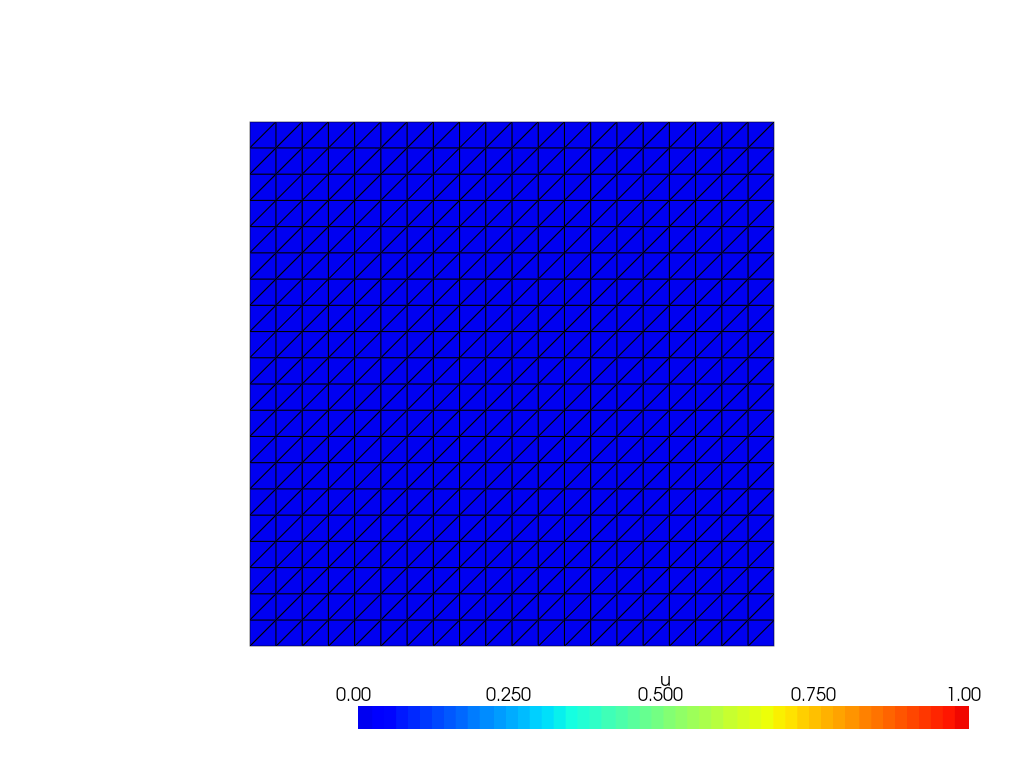

In [15]:
from IPython.display import Image
display(Image(data=open("results/"+problemName+".gif",'rb').read(), format='png'))

In [16]:
pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()

V = fem.VectorFunctionSpace(domain,("Lagrange",2))
u_n = fem.Function(V)
u_ex = Expression(FenicxProblem.w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)

topology, cells, geometry = plot.vtk_mesh(V)

function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")

warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 67.5])

# Compute magnitude of displacement to visualize in GIF 
Vs = FunctionSpace(domain,("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(u_n[1], Vs.element.interpolation_points())
magnitude.interpolate(Mises_Vis)
warped["mag"] = magnitude.x.array
#print(u_n.function_space.dofmap.list)
plotter.update_scalars(magnitude.x.array,render = False)
#plotter.camera.position=[5,25,200]
#plotter.camera.focal_point=[5,40,0]
plotter.render()
plotter.show()


  V = fem.VectorFunctionSpace(domain,("Lagrange",2))



Widget(value="<iframe src='http://localhost:57597/index.html?ui=P_0x2a1334a50_0&reconnect=auto' style='width: …